## Visualization of Tibet dynamic model
### D. Li, 24.1.2022
#### Modified by J. Hayek, 26.01.22

In [1]:
# initialize and load modules
#%matplotlib notebook
from pythonXdmfReader.pythonXdmfReader import*
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('science')

import matplotlib.tri as tri
import pyproj
import scipy.io as sio
from palettable.scientific import sequential as cm
from scipy import spatial

from scipy.io import netcdf_file as netcdf


import rasterio
from rasterio.plot import show
import numpy as np
import os

from Lib_GeneralFunctions import *

print('module loaded')

module loaded


In [2]:
#Plot fontsize controller
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
FontSizeControlFreak(SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE)

# Setup folder and model


In [68]:
ModelFolder = '/import/freenas-m-05-seissol/jhayek/Data_SupNG/Qinghai/'
# model name
modelname = 'c15' #C3,5,6,7
print('model = '+ modelname)

model = c15


## Plot moment rate against time


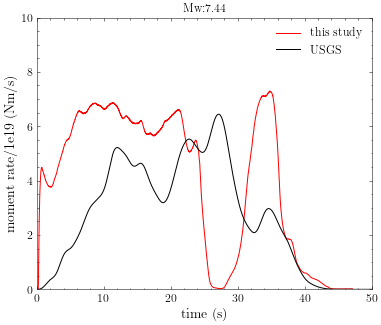

In [69]:
## plot moment rate with time

fin = open(ModelFolder+modelname+'-EnF_0t-all.dat','r') ## Concat file after postprocessing all the Enf files
enf = np.loadtxt(fin,comments='#',skiprows=1); # Moment rate output

mfile='STF_usgs.txt' # Source time function from the USGS, located in the same folder as the notebook
fin2 = open(mfile,'r');
mr = np.loadtxt(fin2);


#%%%%%%%%% Plotting + units conversion to compare against USGS
plt.figure(figsize=(6,5))

#plt.subplot(1,2,1)               
plt.plot(enf[:,0],enf[:,1]*1e7/1e25,'-r')   # from MPa*m**2/s to dyne-cm/s
plt.plot(mr[:,0],mr[:,1]/1e18,'-k')
plt.legend(['this study','USGS'])

plt.xlabel('time (s)')
plt.ylabel('moment rate/1e19 (Nm/s)')
plt.xlim([0,50])
plt.ylim([0,10])


# seismic moment magnitude
moment0 = 0.0
M0 = np.trapz(enf[:,1], x=enf[:,0]) # Trapezoidal rule for integration

mag  = 2/3*np.log10(M0)-6.07 # Conversion to moment magnitude for the title

plt.title('Mw:'+str(round(mag,2)))
plt.savefig(modelname+'-mag.png',dpi=300)


# Surface displacement plot

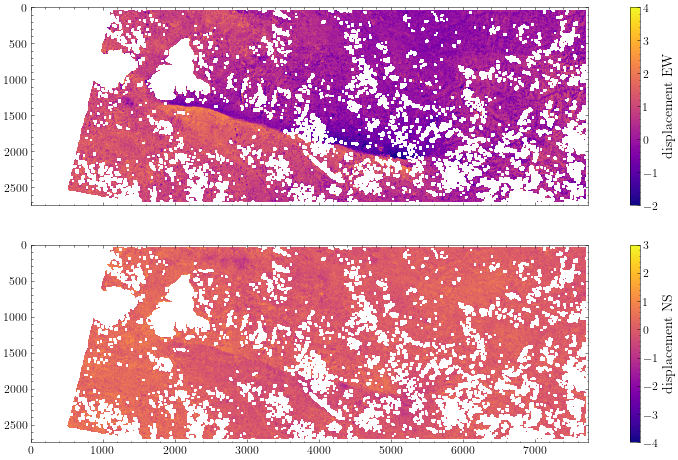

In [73]:
TiffFigure = "InData/disp_ewns.tif"
raster = rasterio.open(TiffFigure)
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(15,8), sharex=True)

Band1 = raster.read(1) #displacement EW saved in raster band 1
Band2 = raster.read(2) #displacement NS saved in raster band 2

Cmap = "plasma"##cm.LaJolla_20.mpl_colormap

img = ax1.imshow(Band1, cmap=Cmap,vmin=-2, vmax=4)
cbar = fig.colorbar(img, ax=ax1)
cbar.set_label('displacement EW')

img2 = ax2.imshow(Band2, cmap=Cmap,vmin=-4, vmax=3)
cbar = fig.colorbar(img2, ax=ax2)
cbar.set_label('displacement NS')


# Plot of rupture velocity and slip

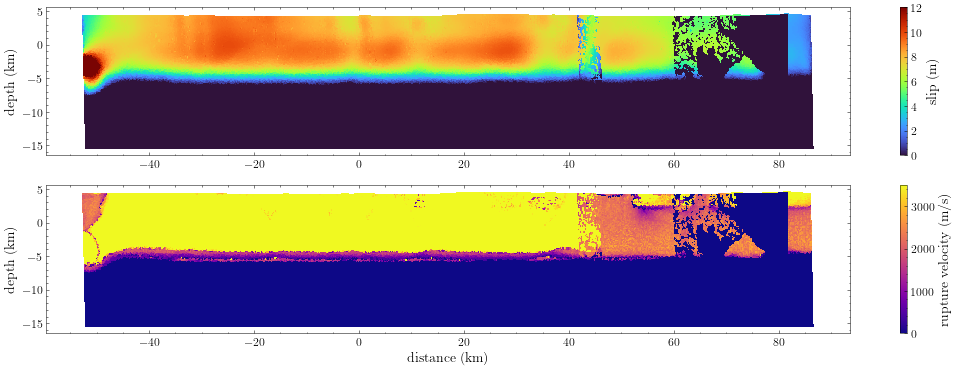

In [61]:
# load data

lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
myproj = pyproj.Proj(proj='lcc', init='EPSG:3415')

xdmfFilename = ModelFolder + modelname+'-fault.xdmf'

hypoll = np.loadtxt('/import/freenas-m-05-seissol/dli/Qinghai/' + 'hypocenters.dat')

#lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
#myproj = pyproj.Proj(proj='geocent',init='EPSG:5936',ellps='WGS84', datum='WGS84')

ndt = ReadNdt(xdmfFilename)-2
xyz = ReadGeometry(xdmfFilename)
connect = ReadConnect(xdmfFilename)

#ncst = pyproj.transform(lla, myproj, coast['data'][:,0],coast['data'][:,1], radians=False)
#hypoxyz =  pyproj.transform(lla, myproj,hypoll[:,0],hypoll[:,1],radians=False)
d = 101.0/180.0*np.pi
triang = tri.Triangulation((xyz[:,0]/1e3-hypoll[0]/1e3)/np.sin(d),xyz[:,2]/1e3,connect)

#%%
asl= LoadData(xdmfFilename,'ASl',connect.shape[0],idt=ndt-1,oneDtMem=True,firstElement=-1)
vr =LoadData(xdmfFilename,'Vr',connect.shape[0],idt=ndt-1,oneDtMem=True,firstElement=-1)
td = LoadData(xdmfFilename,'T_d',connect.shape[0],idt=ndt-1,oneDtMem=True,firstElement=-1)
# srd=LoadData(xdmfFilename,'PSR',connect.shape[0],idt=ndt-1,oneDtMem=True,firstElement=-1)
#%%

fig=plt.figure(figsize=(18,6.0))


#ax0.set_title('Mapview of Td0')
ax0 = fig.add_subplot(2, 1, 1)
sc = ax0.tripcolor(triang,asl[0],cmap='turbo',vmin=0.0,vmax=12.0)
ax0.set_xlabel('')
ax0.set_ylabel('depth (km)')

cl = fig.colorbar(sc,ax=ax0)
cl.set_label('slip (m)')

ax0 = fig.add_subplot(2, 1, 2)
sc = ax0.tripcolor(triang,vr[0],cmap='plasma',vmin=0.0,vmax=3500.0)
ax0.set_xlabel('distance (km)')
ax0.set_ylabel('depth (km)')
cl = fig.colorbar(sc,ax=ax0)
cl.set_label('rupture velocity (m/s)')

outname = modelname+'-slp-vr.png'
plt.savefig(outname,dpi=100,transparent=False)


In [62]:
## plot slip and rupture speed
# load data for snapshot
srd1= LoadData(xdmfFilename,'SRd',connect.shape[0],idt=8,oneDtMem=True,firstElement=-1)
srd2= LoadData(xdmfFilename,'SRd',connect.shape[0],idt=16,oneDtMem=True,firstElement=-1)
srd3= LoadData(xdmfFilename,'SRd',connect.shape[0],idt=30,oneDtMem=True,firstElement=-1)
srd4 =LoadData(xdmfFilename,'SRd',connect.shape[0],idt=42,oneDtMem=True,firstElement=-1)
srd5 =LoadData(xdmfFilename,'SRd',connect.shape[0],idt=54,oneDtMem=True,firstElement=-1)

# srd6 =LoadData(xdmfFilename,'SRd',connect.shape[0],idt=int(5*ndt/6),oneDtMem=True,firstElement=-1)

In [63]:
max(srd2[0])

3.5944160700970933

Vmax=3.5944160700970933; Vmin=-4.31547766474879


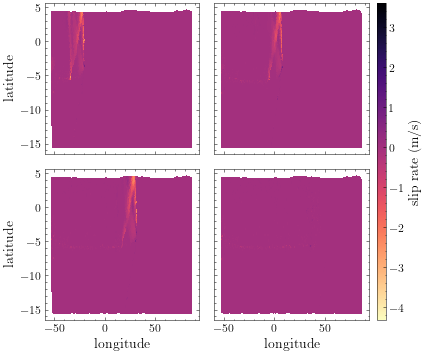

<Figure size 252x189 with 0 Axes>

In [65]:
# plot snapshots of slip rate
fig,([ax0,ax1],[ax2,ax3]) = plt.subplots(nrows=2,ncols=2,figsize=(6,5.5))

#%%%% Selection of colorbar limits
Vmax=max(srd2[0]);Vmin=min(srd2[0])
print("Vmax={}; Vmin={}".format(Vmax,Vmin))
#Vmax=1;Vmin=0
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

sc = ax0.tripcolor(triang,srd2[0],cmap='magma_r',shading='flat',vmin=Vmin,vmax=Vmax)
#cl = fig.colorbar(sc,ax=ax0)
#ax0.set(xlim=(-102.5, -99.5),ylim=(16,18.5))
#ax0.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
# ax0.contour(X,Y,coslp,levels=[8,16],colors='w')
ax0.xaxis.set_ticklabels([])
ax0.set_ylabel('latitude')
#ax0.plot(epi[:,0],epi[:,1],'*r',markersize=4.0)

sc = ax1.tripcolor(triang,srd3[0],cmap='magma_r',shading='flat',vmin=Vmin,vmax=Vmax)
#cl = fig.colorbar(sc,ax=ax1)
#ax1.set(xlim=(-102.5, -99.5),ylim=(16,18.5))
#ax1.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax1.xaxis.set_ticklabels([])
ax1.yaxis.set_ticklabels([])

# ax0.contour(X,Y,coslp,levels=[8,16],colors='w')

sc = ax2.tripcolor(triang,srd4[0],cmap='magma_r',shading='flat',vmin=Vmin,vmax=Vmax)
#cl = fig.colorbar(sc,ax=ax2)
#ax2.set(xlim=(-102.5, -99.5),ylim=(16,18.5))
#ax2.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
# ax0.contour(X,Y,coslp,levels=[8,16],colors='w')
ax2.set_xlabel('longitude')
ax2.set_ylabel('latitude')

sc = ax3.tripcolor(triang,srd5[0],cmap='magma_r',shading='flat',vmin=Vmin,vmax=Vmax)
#cl = fig.colorbar(sc,ax=ax3)
#ax3.set(xlim=(-102.5, -99.5),ylim=(16,18.5))
#ax3.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
# ax3.contour(X,Y,coslp,levels=[8,16],colors='w')
ax3.yaxis.set_ticklabels([])
ax3.set_xlabel('longitude')


fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.85,
                    wspace=0.1, hspace=0.1)
cb_ax = fig.add_axes([0.87, 0.1, 0.02, 0.8])
cbar = fig.colorbar(sc, cax=cb_ax)
cbar.set_label('slip rate (m/s)')

plt.show()
outname = modelname+'-snapshots.png'
plt.savefig(outname,dpi=200,transparent=False)
